# 2P-Fairdivision-IndivisibleItems

## Introduction
The aim of this project is to benchmark some alogorithm design to allocate items to two agents. This notebook focuses on same-size allocations, meaning that each agent should receive the same number of goods. As an additional constraint, items are not divisible.

This notebook is inspired by D. Marc Kilgour and Rudolf Vetschera article named *Comparing direct algoriths for two-player fair division of indivisible items - A computational study* you can found [here](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2997431)

## How to use this notebook
This notebook shows how to use algorithms and get properties of returned allocations. Several classes are defined to help you to create your own algorithms and properties :
  * Agent, which store preferences of an agent as long as some helper methods like getting the to ranked item, get the Borda score of a provided allocation ... Take a look to see what can be done !
  * Good, which is a simple wrapper to represent items. It has some nice printing  and comparison methods
  * ...
In the `properties` module, you can find a bunch of functions. They are designed to test several allocation properties such as Pareto-Optimality, Max-Min property and more.

## First steps
Let's create two agents with their preferences. As a start, we will also create 4 items to divide among agents.

In [1]:
# Manipulate path
import os
import sys
sys.path.insert(0, os.path.join(os.getcwd(), 'fairdiv'))

# Import fairdiv
import fairdiv


# Create some constants
NUMBER_OF_GOODS = 4

# Create items
items = [fairdiv.Good(i) for i in range(NUMBER_OF_GOODS)]

# Create agents. We will consider that item's number is their rank in preferences of the first agent
agents = [
    fairdiv.Agent(name="A", pref=items[:]),
    fairdiv.Agent(name="B", pref=[items[0], items[2], items[1], items[3]])
]

Once items and agents are created, you can use one of the available algorithm to compute an allocation. Let's use a sequential algorithm named `bottom_up`.
This algorithm generates two allocations, one when agent A is the first agent to pick an item and an other when it is agent B.

In [2]:
# Import algorithms
import fairdiv.algorithm as algorithm


# Use bottom-up to compute two allocations
(x1, x2) = algorithm.bottom_up(agents, items)
print(x1)
print(x2)

{B: (2, 3), A: (0, 1)}
{B: (0, 2), A: (1, 3)}


Once you generated some allocations, you can test different properties with the `properties` module. Let's benchmark our allocations `x1` and `x2` to see how beautiful they are !

In [3]:
# Import module
import fairdiv.properties as properties


# Test some of them
print(properties.is_borda_envy_free(x1, agents))
print(properties.is_borda_envy_free(x2, agents))

False
False


Some properties need to get all possible allocations for a given item set size. To generate them, use `Allocation.generate_all_allocations`.

In [4]:
# Generate all allocations for our problem
A = list(fairdiv.Allocation.generate_all_allocations(agents, items))
print(A)

# Use them in properties
print(properties.is_pareto(x1, A, agents))
print(properties.is_pareto(x2, A, agents))

[{B: (0, 2), A: (1, 3)}, {B: (1, 2), A: (0, 3)}, {B: (0, 1), A: (2, 3)}, {B: (1, 3), A: (0, 2)}, {B: (2, 3), A: (0, 1)}, {B: (0, 3), A: (1, 2)}]
True
True


## Test a large amount of properties
Because the number of properties to test is possibly hudge, we designed a class called `Statistics` with which you can store computed allocations and automatically test a bunch of properties easly.
First you need to create a new `Statistics` object.

In [5]:
import statistics as stats


# Create a new Statistics object for storing allocations from bottom_up
bu_stats = stats.Statistics(A, agents, {
    "is_borda_envy_free": lambda X, A, M: properties.is_borda_envy_free(X, M),
    "is_envy_free": lambda X, A, M: properties.is_envy_free(X, M),
    "is_borda_max_min": properties.is_borda_max_min,
    "is_borda_nash": properties.is_borda_nash
})

Now you can add allocations to your object. Each time a new allocation is added, desired properties are tested and the result is stored. You can then print the result or save it in a file.

In [6]:
# Add allocations
bu_stats.add(x1)
bu_stats.add(x2)

# Print the result
print(bu_stats.formatted_text())

Allocations:
	Allocation: {B: (2, 3), A: (0, 1)}
		is_borda_max_min: False
		is_borda_envy_free: False
		is_borda_nash: True
		is_envy_free: True
	Allocation: {B: (0, 2), A: (1, 3)}
		is_borda_max_min: False
		is_borda_envy_free: False
		is_borda_nash: True
		is_envy_free: True



## Reproducing examples
In this section, we are going to test our algorithm using problems defined in the article. This will allow us to demonstrate that our algorithm are correct.

### First Problem
Benchmarking OS algorithm with the given problem :
  * 4 items
  * B preferences are $1 \succ 3 \succ 2 \succ 4$

The algorithm should produce 6 allocations, but only 4 unique ones.

In [2]:
# Manipulate path
import os
import sys
sys.path.insert(0, os.path.join(os.getcwd(), 'fairdiv'))

import fairdiv
import statistics as stats
import fairdiv.algorithm as algorithm
import fairdiv.properties as props


# Create some constants
NUMBER_OF_GOODS = 4

# Create items
items = [fairdiv.Good(i+1) for i in range(NUMBER_OF_GOODS)]

# Create agents. We will consider that item's number is their rank in preferences of the first agent
agents = [
    fairdiv.Agent(name="A", pref=items[:]),
    fairdiv.Agent(name="B", pref=[items[0], items[2], items[1], items[3]])
]

# Generate all allocations for the given problem
A = list(fairdiv.Allocation.generate_all_allocations(agents, items))
for alloc in A:
    print('{} -> {}'.format(alloc, props.is_envy_free_ordinally(alloc, agents)))

result = algorithm.original_sequential(agents, items)
print("OS: {}".format(result))

TR = algorithm.trump_algorithm(agents, items)
print("TR: {}".format(TR))
for alloc in TR:
    print(props.is_pareto_ordinally(alloc, A, M))


{B: (2, 4), A: (1, 3)} -> False
{B: (3, 4), A: (1, 2)} -> False
{B: (1, 4), A: (2, 3)} -> True
{B: (1, 2), A: (3, 4)} -> False
{B: (2, 3), A: (1, 4)} -> True
{B: (1, 3), A: (2, 4)} -> False
OS: [{B: (3, 4), A: (1, 2)}, {B: (1, 4), A: (2, 3)}, {B: (2, 3), A: (1, 4)}, {B: (1, 3), A: (2, 4)}]
TR: []


### Second problem
We are benchmarking all algorithm with the given problem:
  * 8 items
  * B's ranking is : $2 \succ 4 \succ 5 \succ 6 \succ 7 \succ 8 \succ 1 \succ 3$

Results should be :
  * OS is the only algorithm that generates allocation `(1,3,5,6)|(2,4,7,8)`
  * Only OS algoithm can allocate $5$ and $6$ to the same player
  * Allocation `(1,3,4,7)|(2,5,6,8)` is not MM (max-min)


In [8]:
import os
import sys
sys.path.insert(0, os.path.join('.', 'fairdiv'))

import fairdiv
import statistics as stats
import fairdiv.algorithm as algorithm
import fairdiv.properties as properties


# Create some constants
NUMBER_OF_GOODS = 8

# Create items
items = [fairdiv.Good(i+1) for i in range(NUMBER_OF_GOODS)]

# Create agents. We will consider that item's number is their rank in preferences of the first agent
agents = [
    fairdiv.Agent(name="A", pref=items[:]),
    fairdiv.Agent(name="B", pref=[items[1], items[3], items[4], items[5], items[6], items[7], items[0], items[2]])
]

# Generate all allocations for the given problem
A = list(fairdiv.Allocation.generate_all_allocations(agents, items))


results = {
    "OS": algorithm.original_sequential(agents, items),
    "RS": algorithm.restricted_sequential(agents, items),
    "SD": algorithm.singles_doubles(agents, items),
    "BU": algorithm.bottom_up(agents, items),
    "TR": algorithm.trump_algorithm(agents, items)
}

for k, v in results.items():
    print("{}: {}".format(k, v))

print("\nMax-min property for OS allocations:")
for alloc in results["OS"]:
    print("\t{}: {}".format(alloc, properties.is_max_min(alloc, A, agents)))

BU: [{B: (4, 6, 7, 8), A: (1, 2, 3, 5)}, {B: (2, 5, 7, 8), A: (1, 3, 4, 6)}]
SD: [{B: (2, 5, 7, 8), A: (1, 3, 4, 6)}, {B: (2, 6, 7, 8), A: (1, 3, 4, 5)}]
OS: [{B: (2, 4, 6, 8), A: (1, 3, 5, 7)}, {B: (2, 4, 7, 8), A: (1, 3, 5, 6)}, {B: (2, 5, 6, 8), A: (1, 3, 4, 7)}]
RS: [{B: (2, 4, 6, 8), A: (1, 3, 5, 7)}]
TR: [{B: (2, 5, 7, 8), A: (1, 3, 4, 6)}]

Max-min property for OS allocations:
	{B: (2, 4, 6, 8), A: (1, 3, 5, 7)}: False
	{B: (2, 4, 7, 8), A: (1, 3, 5, 6)}: True
	{B: (2, 5, 6, 8), A: (1, 3, 4, 7)}: False


### Third Problem
The third problem is the following :
  * 8 items
  * B's ranking is $4 \succ 7 \succ 2 \succ 3 \succ 6 \succ 1 \succ 8 \succ 5$

Results should be :
  * BU is the only algorithm that find allocation `(1,3,5,6)|(2,4,7,8)`
  * All to-down algorithm allocate item $2$ to $A$


In [9]:
import os
import sys
sys.path.insert(0, os.path.join('.', 'fairdiv'))

import fairdiv
import statistics as stats
import fairdiv.algorithm as algorithm
import fairdiv.properties as properties


# Create some constants
NUMBER_OF_GOODS = 8

# Create items
items = [fairdiv.Good(i+1) for i in range(NUMBER_OF_GOODS)]

# Create agents. We will consider that item's number is their rank in preferences of the first agent
agents = [
    fairdiv.Agent(name="A", pref=items[:]),
    fairdiv.Agent(name="B", pref=[items[3], items[6], items[1], items[2], items[5], items[0], items[7], items[4]])
]

# Generate all allocations for the given problem
A = list(fairdiv.Allocation.generate_all_allocations(agents, items))


results = {
    "OS": algorithm.original_sequential(agents, items),
    "RS": algorithm.restricted_sequential(agents, items),
    "SD": algorithm.singles_doubles(agents, items),
    "BU": algorithm.bottom_up(agents, items),
    "TR": algorithm.trump_algorithm(agents, items)
}

for k, v in results.items():
    print("{}: {}".format(k, v))

BU: [{B: (4, 6, 7, 8), A: (1, 2, 3, 5)}, {B: (2, 4, 7, 8), A: (1, 3, 5, 6)}]
SD: [{B: (3, 4, 7, 8), A: (1, 2, 5, 6)}, {B: (4, 6, 7, 8), A: (1, 2, 3, 5)}, {B: (2, 4, 7, 8), A: (1, 3, 5, 6)}]
OS: [{B: (3, 4, 7, 8), A: (1, 2, 5, 6)}, {B: (4, 6, 7, 8), A: (1, 2, 3, 5)}]
RS: [{B: (3, 4, 7, 8), A: (1, 2, 5, 6)}, {B: (4, 6, 7, 8), A: (1, 2, 3, 5)}]
TR: [{B: (4, 6, 7, 8), A: (1, 2, 3, 5)}]


### Fourth problem
The problem is the following :
  * 8 items
  * B's ranking is : $2 \succ 5 \succ 6 \succ 1 \succ 7 \succ 3 \succ 8 \succ 4$

We expect the following results :
  * SD is the only algorithm that find allocation `(1,3,4,6)|(2,5,7,8)`
  * RS and OS allocate item 6 to player $B$
  * other algorithm allocate items 6, 7 and 8 to $B$


In [10]:
import os
import sys
sys.path.insert(0, os.path.join('.', 'fairdiv'))

import fairdiv
import statistics as stats
import fairdiv.algorithm as algorithm
import fairdiv.properties as properties


# Create some constants
NUMBER_OF_GOODS = 8

# Create items
items = [fairdiv.Good(i+1) for i in range(NUMBER_OF_GOODS)]

# Create agents. We will consider that item's number is their rank in preferences of the first agent
agents = [
    fairdiv.Agent(name="A", pref=items[:]),
    fairdiv.Agent(name="B", pref=[items[1], items[4], items[5], items[0], items[6], items[2], items[7], items[3]])
]

# Generate all allocations for the given problem
A = list(fairdiv.Allocation.generate_all_allocations(agents, items))


results = {
    "OS": algorithm.original_sequential(agents, items),
    "RS": algorithm.restricted_sequential(agents, items),
    "SD": algorithm.singles_doubles(agents, items),
    "BU": algorithm.bottom_up(agents, items),
    "TR": algorithm.trump_algorithm(agents, items)
}

for k, v in results.items():
    print("{}: {}".format(k, v))

BU: [{B: (5, 6, 7, 8), A: (1, 2, 3, 4)}, {B: (2, 6, 7, 8), A: (1, 3, 4, 5)}]
SD: [{B: (2, 5, 6, 8), A: (1, 3, 4, 7)}, {B: (2, 6, 7, 8), A: (1, 3, 4, 5)}, {B: (2, 5, 7, 8), A: (1, 3, 4, 6)}]
OS: [{B: (2, 5, 6, 8), A: (1, 3, 4, 7)}]
RS: [{B: (2, 5, 6, 8), A: (1, 3, 4, 7)}]
TR: [{B: (2, 6, 7, 8), A: (1, 3, 4, 5)}]


### Fifth Problem
Problem is :
  * 8 items
  * B's ranking is: $3 \succ 4 \succ 6 \succ 1 \succ 8 \succ 5 \succ 2 \succ 7$

We expect all algorithm should allocate 4 to $B$ and 5 to $A$

In [11]:
import os
import sys
sys.path.insert(0, os.path.join('.', 'fairdiv'))

import fairdiv
import statistics as stats
import fairdiv.algorithm as algorithm
import fairdiv.properties as properties


# Create some constants
NUMBER_OF_GOODS = 8

# Create items
items = [fairdiv.Good(i+1) for i in range(NUMBER_OF_GOODS)]

# Create agents. We will consider that item's number is their rank in preferences of the first agent
agents = [
    fairdiv.Agent(name="A", pref=items[:]),
    fairdiv.Agent(name="B", pref=[items[2], items[3], items[5], items[0], items[7], items[4], items[1], items[6]])
]

# Generate all allocations for the given problem
A = list(fairdiv.Allocation.generate_all_allocations(agents, items))


results = {
    "OS": algorithm.original_sequential(agents, items),
    "RS": algorithm.restricted_sequential(agents, items),
    "SD": algorithm.singles_doubles(agents, items),
    "BU": algorithm.bottom_up(agents, items),
    "TR": algorithm.trump_algorithm(agents, items)
}

for k, v in results.items():
    print("{}: {}".format(k, v))

BU: [{B: (3, 4, 6, 8), A: (1, 2, 5, 7)}, {B: (4, 5, 6, 8), A: (1, 2, 3, 7)}]
SD: [{B: (3, 4, 6, 8), A: (1, 2, 5, 7)}, {B: (3, 5, 6, 8), A: (1, 2, 4, 7)}]
OS: [{B: (3, 4, 6, 8), A: (1, 2, 5, 7)}]
RS: [{B: (3, 4, 6, 8), A: (1, 2, 5, 7)}]
TR: [{B: (3, 4, 6, 8), A: (1, 2, 5, 7)}]


### First Borda Problem
Problem is the following:
  * $N = 10$
  * B's ranking is: $3 \succ 4 \succ 5 \succ 6 \succ 7 \succ 8 \succ 1 \succ 2$

What we can expect is :
  * OS is the only algorithm to assign `(1,2,5,6)` to $A$
  * All algorithms except RS find allocation `(1,2,4,6)` which is not borda-max-min

In [12]:
import os
import sys
sys.path.insert(0, os.path.join('.', 'fairdiv'))

import fairdiv
import fairdiv.algorithm as algorithm
import fairdiv.properties as props


# Create some constants
NUMBER_OF_GOODS = 8

# Create items
items = [fairdiv.Good(i+1) for i in range(NUMBER_OF_GOODS)]

# Create agents. We will consider that item's number is their rank in preferences of the first agent
agents = [
    fairdiv.Agent(name="A", pref=items[:]),
    fairdiv.Agent(name="B", pref=[items[2], items[3], items[4], items[5], items[6], items[7], items[0], items[1]])
]

# Generate all allocations for the given problem
A = list(fairdiv.Allocation.generate_all_allocations(agents, items))


results = {
    "OS": algorithm.original_sequential(agents, items),
    "RS": algorithm.restricted_sequential(agents, items),
    "SD": algorithm.singles_doubles(agents, items),
    "BU": algorithm.bottom_up(agents, items),
    "TR": algorithm.trump_algorithm(agents, items)
}

for k, v in results.items():
    print("{}: {}".format(k, v))


BU: [{B: (4, 6, 7, 8), A: (1, 2, 3, 5)}, {B: (3, 5, 7, 8), A: (1, 2, 4, 6)}]
SD: [{B: (3, 6, 7, 8), A: (1, 2, 4, 5)}, {B: (3, 5, 7, 8), A: (1, 2, 4, 6)}]
OS: [{B: (3, 4, 7, 8), A: (1, 2, 5, 6)}, {B: (3, 4, 6, 8), A: (1, 2, 5, 7)}]
RS: [{B: (3, 4, 6, 8), A: (1, 2, 5, 7)}]
TR: [{B: (3, 5, 7, 8), A: (1, 2, 4, 6)}]


<function print>

The OS algorithm is not generating allocation `(1,2,4,6)|(3,5,7,8)` as expected. We don't know if it is our algorithm or if we didn't understood the article's sentence.

### Second Borda Problem
The problem is the following :
  * $N = 8$
  * B's ranking is: $5 \succ 8 \succ 2 \succ 3 \succ 4 \succ 6 \succ  1 \succ 7$

We expect the following properties:
  * TR is the only algorithm that allocates `(1,2,3,7)` to $A$
  * All other algorithms allocate `(1,2,3,7)`to $A$ and this allocation fulfill all ordinal and Borda properties (defined in the article)


In [13]:
import os
import sys
sys.path.insert(0, os.path.join('.', 'fairdiv'))

import fairdiv
import fairdiv.algorithm as algorithm
import fairdiv.statistics as stats
import fairdiv.properties as props


# Create some constants
NUMBER_OF_GOODS = 8

# Create items
items = [fairdiv.Good(i+1) for i in range(NUMBER_OF_GOODS)]

# Create agents. We will consider that item's number is their rank in preferences of the first agent
agents = [
    fairdiv.Agent(name="A", pref=items[:]),
    fairdiv.Agent(name="B", pref=[items[4], items[7], items[1], items[2], items[3], items[5], items[0], items[6]])
]

# Generate all allocations for the given problem
A = list(fairdiv.Allocation.generate_all_allocations(agents, items))


results = {
    "OS": algorithm.original_sequential(agents, items),
    "RS": algorithm.restricted_sequential(agents, items),
    "SD": algorithm.singles_doubles(agents, items),
    "BU": algorithm.bottom_up(agents, items),
    "TR": algorithm.trump_algorithm(agents, items)
}

for k, v in results.items():
    print("{}: {}".format(k, v))

os_stats = stats.Statistics(A, agents, {
    "BPareto": props.is_borda_pareto,
    "BMaxSum": props.is_maximal_borda_sum,
    "BEnvyFree": lambda X, A, M: props.is_borda_envy_free(X, M),
    "BMaxMin": props.is_borda_max_min,
    "OLEnvyFree": lambda X, A, M: props.is_envy_free_ordinally(X, M),
    # "OLPareto": props.is_pareto_ordinally # Will take a long time
})
for X in results["OS"]:
    os_stats.add(X)

print(os_stats.formatted_text())

BU: [{B: (3, 5, 6, 8), A: (1, 2, 4, 7)}, {B: (2, 5, 6, 8), A: (1, 3, 4, 7)}]
SD: [{B: (2, 5, 6, 8), A: (1, 3, 4, 7)}, {B: (2, 3, 5, 8), A: (1, 4, 6, 7)}, {B: (3, 5, 6, 8), A: (1, 2, 4, 7)}, {B: (3, 4, 5, 8), A: (1, 2, 6, 7)}, {B: (2, 4, 5, 8), A: (1, 3, 6, 7)}]
OS: [{B: (3, 5, 6, 8), A: (1, 2, 4, 7)}]
RS: [{B: (3, 5, 6, 8), A: (1, 2, 4, 7)}]
TR: [{B: (4, 5, 6, 8), A: (1, 2, 3, 7)}, {B: (2, 5, 6, 8), A: (1, 3, 4, 7)}]
Allocations:
	Allocation: {B: (3, 5, 6, 8), A: (1, 2, 4, 7)}
		OLEnvyFree: True
		BEnvyFree: True
		BMaxSum: True
		BPareto: True
		BMaxMin: True



## Extending the article
D. Marc Kilgour and Rudolf Vetschera defined several properties using Ordinally Less relationship and Borda score :
  * EnvyFree using Ordinally Less
  * Pareto using Ordinally Less
  * Envy Free using Borda score
  * Borda max sum
  * Max min using Borda score
  * Max min

In addition of these properties, we propose to define new ones :
  * Nash property using the Borda score, we can define as follow : $\forall Y \in A, \prod_{m \in M} B_m(X_m) \geq \prod_{m \in M} B_m(Y_m)$
  * Pareto, without using the Ordinally Less relationship defined as follow : $\forall Y \in A, \forall m \in M, X_m \succ_{p} Y_m$ For example, if goods are `car`, `plane`, `train` and `boat` and A's preferences are `car` $\succ$ `train` $\succ$ `plane` $\succ$ `boat`, then allocation {`car`, `train`} is pareto because items rank are respectively $1$ and $2$ and there is no other allocation beating that. {`car`, `plane`} is dominated because items rank are $1$ and $3$.
  * Envy Free without using Ordinally Less relationship. An allocation is envy-free if no agent prefers an item allocated to the other. For example, if B'spreferences are `plane` $\succ$ `boat` $\succ$ `car` $\succ$ `train`, then allocation {`car`, `plane`} for A is not envy free because A would like to have `train` and B `plane`.

## Benchmarking algorithms
In this section, we are going to benchmark all algorithms to study produced allocations.

### 4 items problems


In [1]:
import os
import sys
sys.path.insert(0, os.path.join('.', 'fairdiv'))

import fairdiv
import fairdiv.algorithm as algorithm
import fairdiv.statistics as stats
import fairdiv.properties as props
import fairdiv.problemGenerators as generators

# Create some constants
NUMBER_OF_GOODS = 8

# Generate all possible problems (ie, all preferences) for 4 items
problems = generators.generate_possible_problems(4)

# Algorithms to test
algos = {
    "OS": algorithm.original_sequential,
    "RS": algorithm.restricted_sequential,
    "SD": algorithm.singles_doubles,
    "BU": algorithm.bottom_up,
    "TR": algorithm.trump_algorithm
}

# Properties to test
properties = {
        "BPareto": props.is_borda_pareto,
        "BMaxSum": props.is_maximal_borda_sum,
        "BEnvyFree": lambda X, A, M: props.is_borda_envy_free(X, M),
        "BMaxMin": props.is_borda_max_min,
        "BNash": props.is_borda_nash,
        # "BEgalitarian": lambda X, A, M: props.is_borda_egalitarian(X, M),
        "OLEnvyFree": lambda X, A, M: props.is_envy_free_ordinally(X, M),
        "OLPareto": props.is_pareto_ordinally, # Will take a long time
        "Max-min": props.is_max_min,
        "Pareto": props.is_pareto,
        "Envy-free": lambda X, A, M: props.is_envy_free(X, M)
    }

# Benchmark algorithms
benchmark = stats.Benchmark(
    problems,
    algos,
    properties
)

result = benchmark.run()

We can make some charts about allocations. Let's draw the average number of allocations found by the algorithms per problem :

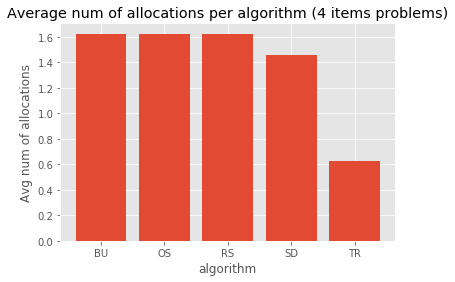

In [2]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt


# Set style
plt.style.use('ggplot')

# Gather data
x = [k for k in result]
y = []
for algo in x:
    avg = 0
    for pb in result[algo]:
        avg += len(result[algo][pb].data)
    avg /= len(result[algo])
    y.append(avg)

# Draw
fig, ax = plt.subplots()
ax.bar(x, y)

# Misc
ax.set(
    xlabel='algorithm',
    ylabel='Avg num of allocations',
    title='Average num of allocations per algorithm (4 items problems)'
)
plt.show()

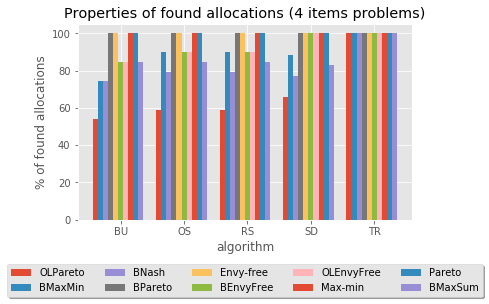

In [3]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt


# Set style
plt.style.use('ggplot')

# Gather data
x = [k for k in result] # Define order
y = []
props = [p for p in properties] # Define order

for algo in x:
    tmp = {}
    nb_alloc = 0
    for pb in result[algo]:
        for alloc in result[algo][pb].data:
            nb_alloc += 1
            for prop in alloc:#result[algo][pb].data[alloc]:
                if prop != "Allocation" and alloc[prop]:
                    if not tmp.get(prop, False):
                        tmp[prop] = 0
                    tmp[prop] += 1
    for prop in tmp:
        tmp[prop] *= 100 / nb_alloc
    y.append([tmp.get(prop, 0) for prop in props])

# Draw
fig, ax = plt.subplots()
gap = 0.4 / len(y)
for i in range(len(props)):
    ax.bar([j + (i - (len(props) // 2)) * gap for j in range(len(x))], [e[i] for e in y], width=gap, label=props[i])

# Misc
ax.set(
    xlabel='algorithm',
    ylabel='% of found allocations',
    title='Properties of found allocations (4 items problems)',
    xticklabels=[0] + x # trick
)

# Shrink current axis's height by 10% on the bottom
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

# Put a legend below current axis
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=5)

plt.show()

#### What we can say
Despite finding a small number of allocations, the Trump algorithm find allocations satisfying all properties. All algorithms are finding both max-min and Borda pareto while only SD can also garanty OL envy-free and Borda envy-free properties.
Can we generalize what we found ? That's what we are going to see by running a benchmark on 6 items problems.

### 6 items problems
Let's run a benchmark on 6 items problems.

In [4]:
import os
import sys
sys.path.insert(0, os.path.join('.', 'fairdiv'))

import fairdiv
import fairdiv.algorithm as algorithm
import fairdiv.statistics as stats
import fairdiv.properties as props
import fairdiv.problemGenerators as generators

# Create some constants
NUMBER_OF_GOODS = 6

# Generate all possible problems (ie, all preferences) for 6 items
problems = generators.generate_possible_problems(NUMBER_OF_GOODS)

# Algorithms to test
algos = {
    "OS": algorithm.original_sequential,
    "RS": algorithm.restricted_sequential,
    "SD": algorithm.singles_doubles,
    "BU": algorithm.bottom_up,
    "TR": algorithm.trump_algorithm
}

# Properties to test
properties = {
        "BPareto": props.is_borda_pareto,
        "BMaxSum": props.is_maximal_borda_sum,
        "BEnvyFree": lambda X, A, M: props.is_borda_envy_free(X, M),
        "BMaxMin": props.is_borda_max_min,
        "BNash": props.is_borda_nash,
        #"BEgalitarian": lambda X, A, M: props.is_borda_egalitarian(X, M),
        "OLEnvyFree": lambda X, A, M: props.is_envy_free_ordinally(X, M),
        "OLPareto": props.is_pareto_ordinally, # Will take a long time
        "Max-min": props.is_max_min,
        "Pareto": props.is_pareto,
        "Envy-free": lambda X, A, M: props.is_envy_free(X, M)
    }

# Benchmark algorithms
benchmark = stats.Benchmark(
    problems,
    algos,
    properties
)

result = benchmark.run()

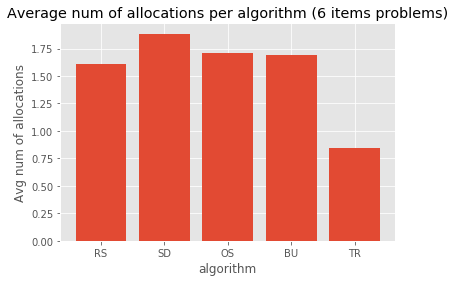

In [6]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt


# Set style
plt.style.use('ggplot')

# Gather data
x = [k for k in result]
y = []
for algo in x:
    avg = 0
    for pb in result[algo]:
        avg += len(result[algo][pb].data)
    avg /= len(result[algo])
    y.append(avg)

# Draw
fig, ax = plt.subplots()
ax.bar(x, y)

# Misc
ax.set(
    xlabel='algorithm',
    ylabel='Avg num of allocations',
    title='Average num of allocations per algorithm (6 items problems)'
)
plt.show()

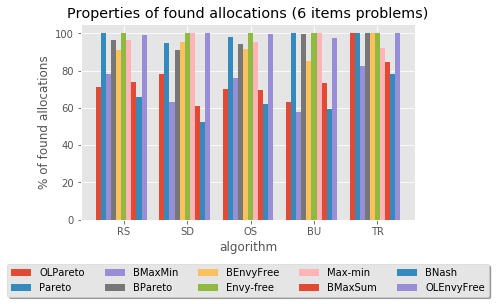

In [8]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt


# Set style
plt.style.use('ggplot')

# Gather data
x = [k for k in result] # Define order
y = []
props = [p for p in properties] # Define order

for algo in x:
    tmp = {}
    nb_alloc = 0
    for pb in result[algo]:
        for alloc in result[algo][pb].data:
            nb_alloc += 1
            for prop in alloc:#result[algo][pb].data[alloc]:
                if prop != "Allocation" and alloc[prop]:
                    if not tmp.get(prop, False):
                        tmp[prop] = 0
                    tmp[prop] += 1
    for prop in tmp:
        tmp[prop] *= 100 / nb_alloc
    y.append([tmp.get(prop, 0) for prop in props])

# Draw
fig, ax = plt.subplots()
gap = 0.4 / len(y)
for i in range(len(props)):
    ax.bar([j + (i - (len(props) // 2)) * gap for j in range(len(x))], [e[i] for e in y], width=gap, label=props[i])

# Misc
ax.set(
    xlabel='algorithm',
    ylabel='% of found allocations',
    title='Properties of found allocations (6 items problems)',
    xticklabels=[0] + x # trick
)

# Shrink current axis's height by 10% on the bottom
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

# Put a legend below current axis
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=5)

plt.show()

#### What we can say
This chart, combined with the one obtained for 4 items problems, show that :
  * TR seems to generate allocations that are always OL Pareto, Borda Pareto, OL envy-free and Borda envy-free
  * Generated allocations by OS and RS are not always max-min and BPareto like we supposed earlier
  * SD seems to find allocations that are max-min and OL envy-free
  * BU seems to generate allocations that are max-min

### 8 items problems

In [5]:
import os
import sys
sys.path.insert(0, os.path.join('.', 'fairdiv'))

import fairdiv
import fairdiv.algorithm as algorithm
import fairdiv.statistics as stats
import fairdiv.properties as props
import fairdiv.problemGenerators as generators

# Create some constants
NUMBER_OF_GOODS = 8

# Generate all possible problems (ie, all preferences) for 8 items
problems = generators.generate_possible_problems(NUMBER_OF_GOODS)

# Algorithms to test
algos = {
    "OS": algorithm.original_sequential,
    "RS": algorithm.restricted_sequential,
    "SD": algorithm.singles_doubles,
    "BU": algorithm.bottom_up,
    "TR": algorithm.trump_algorithm
}

# Properties to test
properties = {
        "BPareto": props.is_borda_pareto,
        "BMaxSum": props.is_maximal_borda_sum,
        "BEnvyFree": lambda X, A, M: props.is_borda_envy_free(X, M),
        "BMaxMin": props.is_borda_max_min,
        "BNash": props.is_borda_nash,
        #"BEgalitarian": lambda X, A, M: props.is_borda_egalitarian(X, M),
        "OLEnvyFree": lambda X, A, M: props.is_envy_free_ordinally(X, M),
        "OLPareto": props.is_pareto_ordinally, # Will take a long time
        "Max-min": props.is_max_min
    }

# Benchmark algorithms
benchmark = stats.Benchmark(
    problems,
    algos,
    properties
)

result = benchmark.run()

KeyboardInterrupt: 